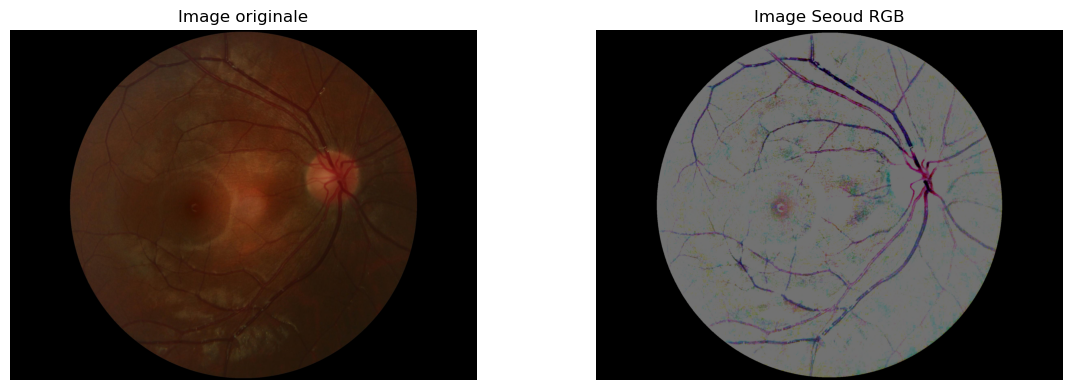

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def fundus_roi(image, mask=None):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    threshold = 15
    _, roi = cv2.threshold(v, threshold, 1, cv2.THRESH_BINARY)
    roi = roi.astype(bool)
    white_pixels = np.argwhere(roi == 1)
    if white_pixels.size == 0:
        print("Aucun pixel blanc trouvé dans le masque.")
        return {"roi": roi, "diameter": 0, "image": image}
    x_min, y_min = np.min(white_pixels, axis=0)
    x_max, y_max = np.max(white_pixels, axis=0)
    diameter_x = x_max - x_min
    diameter_y = y_max - y_min
    diameter = int(np.maximum(diameter_x, diameter_y))
    return {"roi": roi, "diameter": diameter, "image": image}

def apply_seoud(image, roi=None, diameter=None):
    data = fundus_roi(image)
    roi = data["roi"]
    roi = roi.astype(np.uint8)
    D = data["diameter"]
    roi_bool = roi > 0

    mean_img = np.mean(image[roi_bool])
    std_img = np.std(image[roi_bool])
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    dilated_image = cv2.dilate(image, kernel, iterations=25)
    image[roi == 0] = np.mean(image, axis=(0, 1))
    roi = cv2.erode(roi, np.ones((9, 9)), iterations=1)
    expended_roi = np.expand_dims(roi, 2)
    dilated_image[dilated_image[:, :, 0] < 100] = np.mean(dilated_image, axis=(0, 1))

    image = image * expended_roi + (1 - expended_roi) * dilated_image

    h0 = D // 5
    h1 = D // 10
    h2 = D // 360
    h3 = D // 28
    h0 += (h0 + 1) % 2
    h1 += (h1 + 1) % 2
    h2 += (h2 + 1) % 2
    h3 += (h3 + 1) % 2

    blur = cv2.medianBlur(image, min(h1, 255))

    std = local_std(image, h1)
    std = std.clip(std_img, std.max())

    c1s = cv2.split(image)
    c2s = cv2.split(blur)
    out = []
    for c1, c2 in zip(c1s, c2s):
        out.append(cv2.addWeighted(c1, 1, c2, -1, np.mean(image)))
    output = cv2.merge(out)

    hpf = cv2.addWeighted(output, 1, cv2.blur(output, (h3, h3)), -1, np.mean(output))

    output = cv2.addWeighted(output.astype(np.float32), 1, cv2.divide(hpf.astype(np.float32), std + 1e-7), 1, 0).clip(0, 255)

    cs = cv2.split(output)
    out = []
    for c in cs:
        c = (std_img * (c - c.mean()) / c.std()) + 127
        c = c.clip(mean_img - 3 * std_img, mean_img + 3 * std_img)
        out.append(c)

    output = cv2.merge(out).clip(0, 255).astype(np.uint8)
    return {"image": image, "output": output * expended_roi}
 

def local_std(image, size):
    img_sq = cv2.multiply(image.astype(np.float32), image.astype(np.float32))
    E_img_sq = cv2.blur(img_sq, (size, size))

    E_local = cv2.blur(image.astype(np.float32), (size, size))
    sq_E_local = cv2.multiply(E_local, E_local)

    var = cv2.add(E_img_sq, -sq_E_local)
    std = cv2.sqrt(var.clip(1e-3, var.max()))
    return std

list_images = os.listdir('../data')
image_path = os.path.join('../data', list_images[0])
image = cv2.imread(image_path)
    
if image is None:
    print(f"Erreur: Impossible de charger l'image {image_path}.")
else:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    seoud_image = apply_seoud(image)
    
    plt.figure(figsize=(12, 4))
        
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Image originale")
    plt.axis('off')
        
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(seoud_image['output'], cv2.COLOR_BGR2RGB))
    plt.title("Image Seoud RGB")
    plt.axis('off')
        
    plt.tight_layout()
    plt.show()

